# Anwendung prädiktiver Modellierung zur Prognose des Herzinfarktrisikos

In [1]:
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from matplotlib import colors
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline


/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Herunterladen des Datensatz

In [2]:
file_path = "heart_attack_risk_dataset.csv"

# Loading the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "bhimashankar05/heart-attack-dataset",
  file_path
)

/var/folders/9h/z3mlmtj94_9dvg6086vyqt3r0000gn/T/ipykernel_98131/3113864645.py:4: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


## Exploration des unbearbeiteten Datensatz

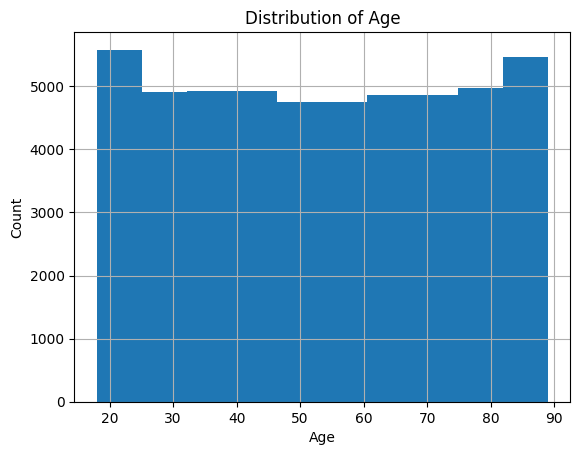

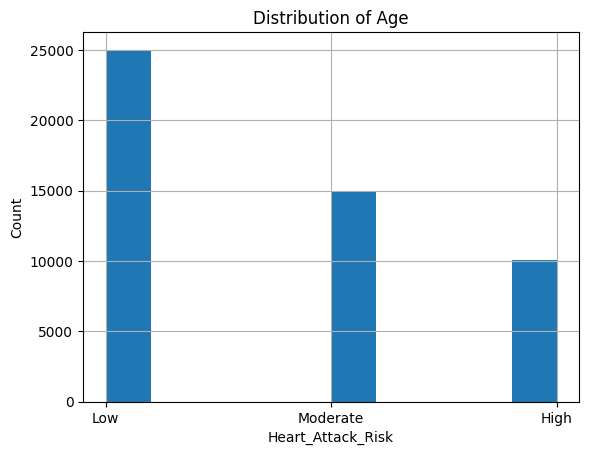

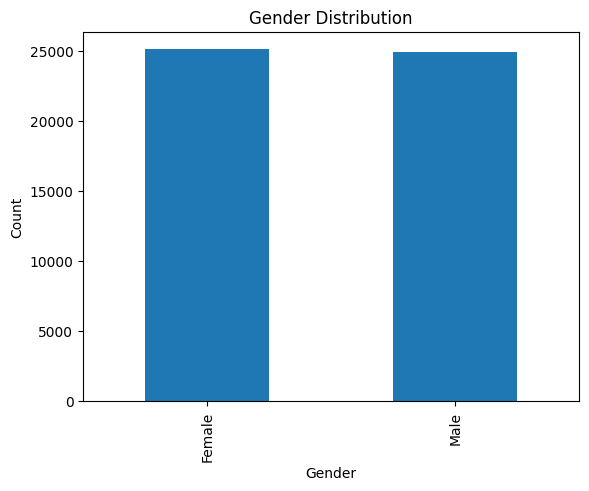

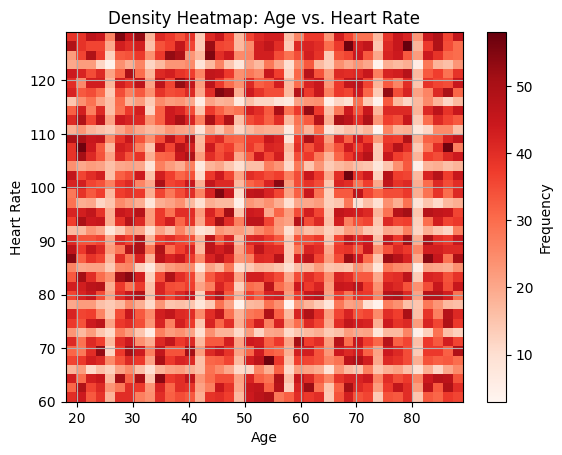

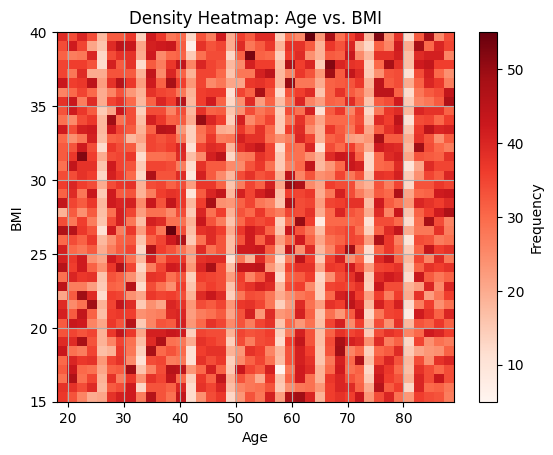

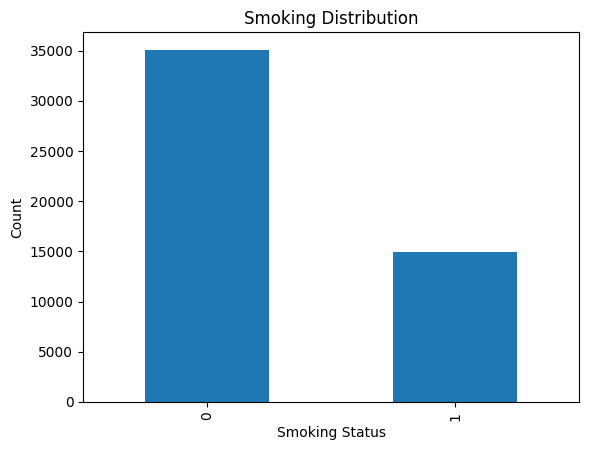

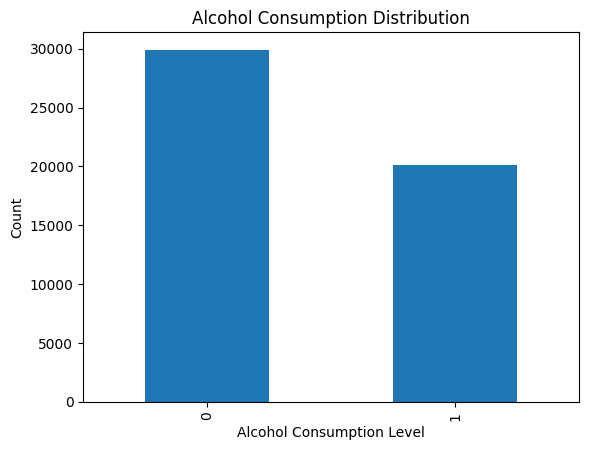

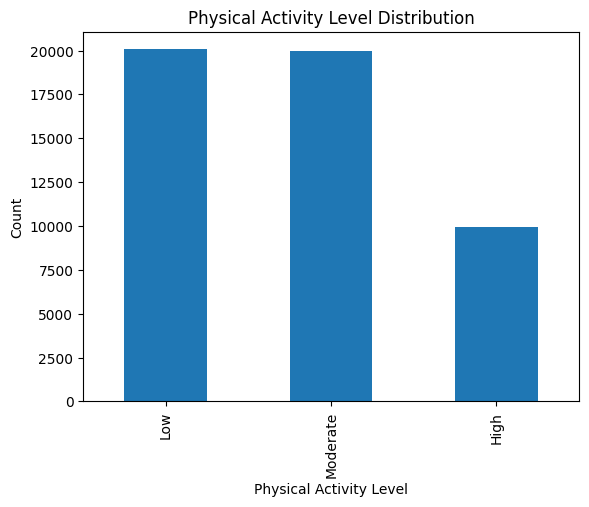

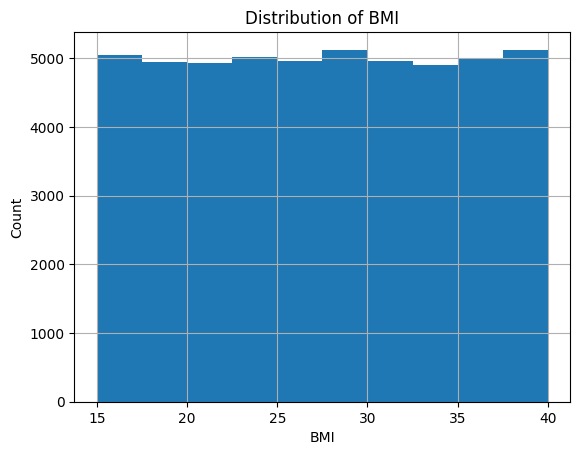

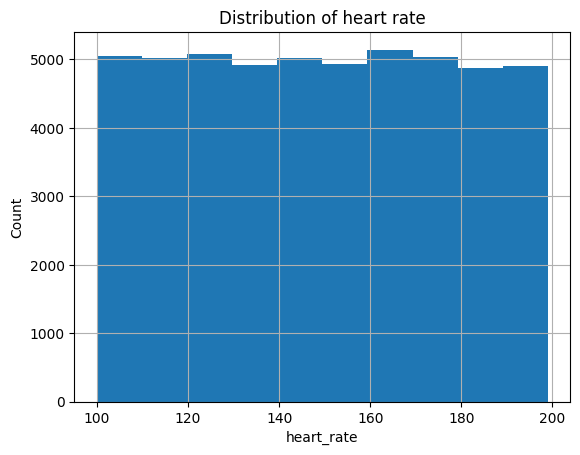

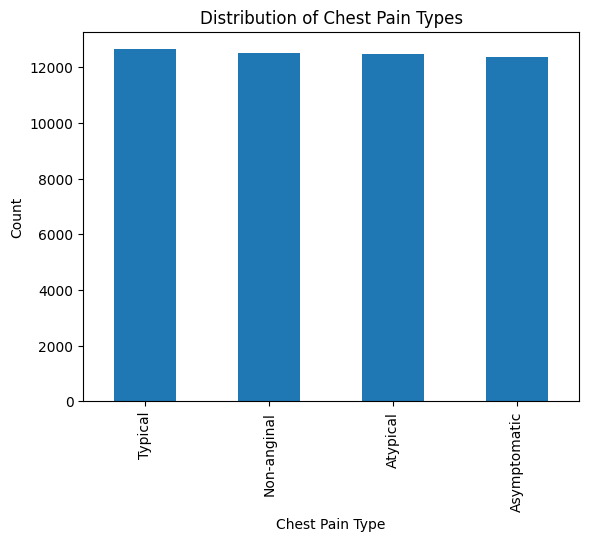

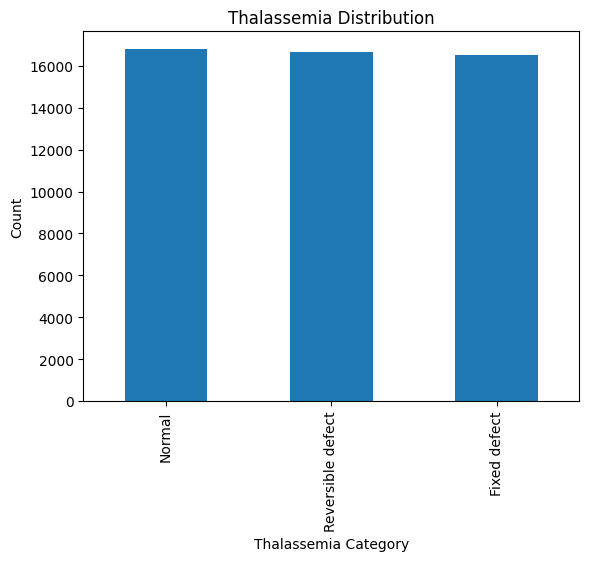

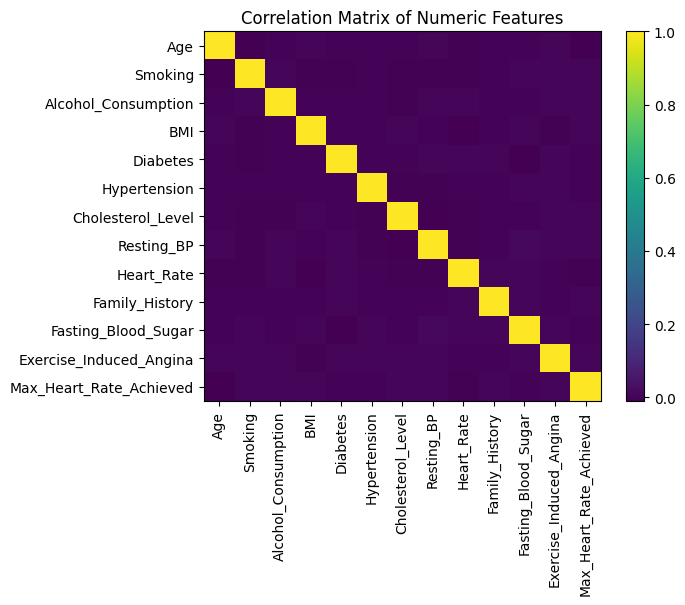

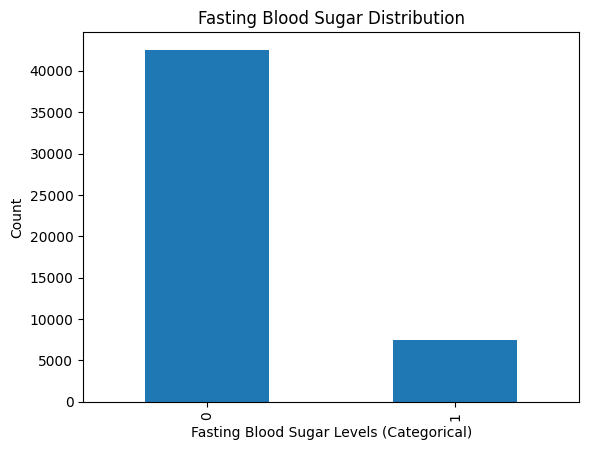

In [3]:
# Categorical Distribution: Age
plt.figure()
df["Age"].hist()
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.show()

# Categorical Distribution: Risk
plt.figure()
df["Heart_Attack_Risk"].hist()
plt.xlabel("Heart_Attack_Risk")
plt.ylabel("Count")
plt.title("Distribution of Age")
plt.show()


# Categorical Distribution: Gender
plt.figure()
df["Gender"].value_counts().plot(kind="bar")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Gender Distribution")
plt.show()


# 2D Histogram (Heatmap): Age vs. Heart Rate
plt.figure()
plt.hist2d(df["Age"], df["Heart_Rate"], bins=40, cmap="Reds")
plt.xlabel("Age")
plt.ylabel("Heart Rate")
plt.title("Density Heatmap: Age vs. Heart Rate")
plt.colorbar(label='Frequency')
plt.grid(True)
plt.show()


# 2D Histogram (Heatmap): Age vs. BMI
plt.figure()
plt.hist2d(df["Age"], df["BMI"], bins=40, cmap="Reds")
plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("Density Heatmap: Age vs. BMI")
plt.colorbar(label='Frequency')
plt.grid(True)
plt.show()


# Categorical Distribution: Smoking
plt.figure()
df["Smoking"].value_counts().plot(kind="bar")
plt.xlabel("Smoking Status")
plt.ylabel("Count")
plt.title("Smoking Distribution")
plt.show()


# Categorical Distribution: Alcohol Consumption
plt.figure()
df["Alcohol_Consumption"].value_counts().plot(kind="bar")
plt.xlabel("Alcohol Consumption Level")
plt.ylabel("Count")
plt.title("Alcohol Consumption Distribution")
plt.show()


# Categorical Distribution: Physical Activity Level
plt.figure()
df["Physical_Activity_Level"].value_counts().plot(kind="bar")
plt.xlabel("Physical Activity Level")
plt.ylabel("Count")
plt.title("Physical Activity Level Distribution")
plt.show()


# Distribution: BMI
plt.figure()
df["BMI"].hist()
plt.xlabel("BMI")
plt.ylabel("Count")
plt.title("Distribution of BMI")
plt.show()


# Scatter Plot: Age vs. Max Heart Rate Achieved
plt.figure()
df["Max_Heart_Rate_Achieved"].hist()
plt.xlabel("heart_rate")
plt.ylabel("Count")
plt.title("Distribution of heart rate")
plt.show()


# Bar Chart: Chest Pain Type
plt.figure()
df["Chest_Pain_Type"].value_counts().plot(kind="bar")
plt.xlabel("Chest Pain Type")
plt.ylabel("Count")
plt.title("Distribution of Chest Pain Types")
plt.show()


# Bar Chart: Thalassemia
plt.figure()
df["Thalassemia"].value_counts().plot(kind="bar")
plt.xlabel("Thalassemia Category")
plt.ylabel("Count")
plt.title("Thalassemia Distribution")
plt.show()


# Correlation Matrix
numeric_df = df.select_dtypes(include=["int64", "float64"])
correlations = numeric_df.corr()

plt.figure()
plt.imshow(correlations, aspect="auto")
plt.colorbar()
plt.title("Correlation Matrix of Numeric Features")

plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.show()

# Bar Chart: Fasting Blood Sugar
plt.figure()
df["Fasting_Blood_Sugar"].value_counts().plot(kind="bar")
plt.xlabel("Fasting Blood Sugar Levels (Categorical)")
plt.ylabel("Count")
plt.title("Fasting Blood Sugar Distribution")
plt.show()


## Generelle verunreinigungen

In [4]:
# Show basic info about the dataset
print("=== Dataset Info ===")
df.info()

# Show unique values per column (helps spot weird/inconsistent entries)
print("\n=== Unique Values Per Column ===")
for column in df.columns:
    print(f"{column}: {df[column].unique()}")

# Select only numeric columns
numeric_cols = df.select_dtypes(include='number').columns
# Find rows where any numeric value is negative
suspicious_negatives = df[(df[numeric_cols] < 0).any(axis=1)]
print("\n=== Rows with Suspicious Negative Numeric Values ===")
print(suspicious_negatives)

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      50000 non-null  int64  
 1   Gender                   50000 non-null  object 
 2   Smoking                  50000 non-null  int64  
 3   Alcohol_Consumption      50000 non-null  int64  
 4   Physical_Activity_Level  50000 non-null  object 
 5   BMI                      50000 non-null  float64
 6   Diabetes                 50000 non-null  int64  
 7   Hypertension             50000 non-null  int64  
 8   Cholesterol_Level        50000 non-null  float64
 9   Resting_BP               50000 non-null  int64  
 10  Heart_Rate               50000 non-null  int64  
 11  Family_History           50000 non-null  int64  
 12  Stress_Level             50000 non-null  object 
 13  Chest_Pain_Type          50000 non-null  object 
 14  T

## Outliers

In [5]:
# Select only numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
# Calculate Z-scores
z_scores = df[numerical_cols].apply(zscore)
# Identify outliers (Z-score > 3 or < -3)
outliers = (z_scores.abs() > 3)

print("Outlier count per column:")
print(outliers.sum())

Outlier count per column:
Age                        0
Smoking                    0
Alcohol_Consumption        0
BMI                        0
Diabetes                   0
Hypertension               0
Cholesterol_Level          0
Resting_BP                 0
Heart_Rate                 0
Family_History             0
Fasting_Blood_Sugar        0
Exercise_Induced_Angina    0
Max_Heart_Rate_Achieved    0
dtype: int64


## Statistische Kennzahlen

In [6]:
numeric_columns = [
    'Age',
    'BMI',
    'Cholesterol_Level',
    'Resting_BP',
    'Heart_Rate',
    'Max_Heart_Rate_Achieved'
]

df_stats = df[numeric_columns].describe()
print("Zentrale Kennwerte der numerischen Variablen:")
print(df_stats)

Zentrale Kennwerte der numerischen Variablen:
                Age           BMI  Cholesterol_Level    Resting_BP  \
count  50000.000000  50000.000000       50000.000000  50000.000000   
mean      53.398700     27.519357         225.036444    134.434100   
std       20.799006      7.225176          43.317373     25.907961   
min       18.000000     15.000000         150.000000     90.000000   
25%       35.000000     21.270000         187.300000    112.000000   
50%       53.000000     27.540000         225.100000    134.000000   
75%       71.000000     33.770000         262.600000    157.000000   
max       89.000000     40.000000         300.000000    179.000000   

         Heart_Rate  Max_Heart_Rate_Achieved  
count  50000.000000             50000.000000  
mean      94.530480               149.305340  
std       20.187124                28.823699  
min       60.000000               100.000000  
25%       77.000000               124.000000  
50%       94.000000               149.000

## Datenpräperierung

In [7]:
# Shuffle the dataset to remove any inherent structure
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# Ordinal Mapping for Specific Columns
# Define the ordinal mapping for Stress_Level and Heart_Attack_Risk.
# Here we assume the following order: Low (1), Moderate (2), High (3).
stress_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
risk_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
physical_activity_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
# basically all the same but for a better overview

df['Physical_Activity_Level'] = df['Physical_Activity_Level'].map(physical_activity_mapping)
df['Stress_Level'] = df['Stress_Level'].map(stress_mapping)
df['Heart_Attack_Risk'] = df['Heart_Attack_Risk'].map(risk_mapping)

# normalizieren der Daten
df['Age'] = df['Age'] / 80
df['BMI'] = df['BMI'] / 40
df['Cholesterol_Level'] = df['Cholesterol_Level'] / 240
df['Resting_BP'] = df['Resting_BP'] / 140
df['Heart_Rate'] = df['Heart_Rate'] / 140
df['Max_Heart_Rate_Achieved'] = df['Max_Heart_Rate_Achieved'] / 80

# One-Hot Encoding for Categorical Variables
# The following columns will be one-hot encoded: Gender, Thalassemia, ECG_Results.
df_encoded = pd.get_dummies(df, columns=['Gender', 'Thalassemia', 'ECG_Results'])

non_clinical_cols = [
    'Age', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 
    'BMI', 'Diabetes', 'Stress_Level', 'Family_History', 'Heart_Attack_Risk'
]
# Append one-hot encoded Gender columns
gender_cols = [col for col in df_encoded.columns if col.startswith('Gender_')]
non_clinical_cols += gender_cols

df_non_clinical = df_encoded[non_clinical_cols].copy()

clinical_cols = [
    'Age', 'Smoking', 'Alcohol_Consumption', 'Physical_Activity_Level', 
    'BMI', 'Diabetes', 'Hypertension', 'Cholesterol_Level', 'Resting_BP', 'Heart_Rate', 
    'Family_History', 'Stress_Level', 'Fasting_Blood_Sugar', 'Exercise_Induced_Angina', 
    'Max_Heart_Rate_Achieved', 'Heart_Attack_Risk'
]
# Append one-hot encoded columns for Gender, Thalassemia, and ECG_Results
gender_cols = [col for col in df_encoded.columns if col.startswith('Gender_')]
thalassemia_cols = [col for col in df_encoded.columns if col.startswith('Thalassemia_')]
ecg_cols = [col for col in df_encoded.columns if col.startswith('ECG_Results_')]
clinical_cols += gender_cols + thalassemia_cols + ecg_cols

df_clinical = df_encoded[clinical_cols].copy()

# encodeing true and false to 0 and 1
df_encoded = df_encoded.map(lambda x: 1 if x is True else (0 if x is False else x))
df_non_clinical = df_non_clinical.map(lambda x: 1 if x is True else (0 if x is False else x))
df_clinical = df_clinical.map(lambda x: 1 if x is True else (0 if x is False else x))


df_encoded.to_csv('data/heart_attack_data_encoded.csv', index=False)
df_non_clinical.to_csv('data/heart_attack_data_non_clinical.csv', index=False)
df_clinical.to_csv('data/heart_attack_data_clinical.csv', index=False)

In [8]:
# -----------------------------
# Split Non-Clinical Dataset
# -----------------------------
df_non_clinical_train, df_non_clinical_temp = train_test_split(
    df_non_clinical, 
    test_size=0.30,
    random_state=42
)

# Split the temp set again 50/50 for val and test => 15% each
df_non_clinical_val, df_non_clinical_test = train_test_split(
    df_non_clinical_temp, 
    test_size=0.50, 
    random_state=42
)

# ---------------------------
# Split Clinical Dataset
# ---------------------------
df_clinical_train, df_clinical_temp = train_test_split(
    df_clinical, 
    test_size=0.30, 
    random_state=42
)

df_clinical_val, df_clinical_test = train_test_split(
    df_clinical_temp, 
    test_size=0.50, 
    random_state=42
)

# print numbers
print("Non-Clinical: Train =", len(df_non_clinical_train), 
      "Val =", len(df_non_clinical_val), 
      "Test =", len(df_non_clinical_test))

print("Clinical: Train =", len(df_clinical_train), 
      "Val =", len(df_clinical_val), 
      "Test =", len(df_clinical_test))

# in the end we have
# df_non_clinical_train, df_non_clinical_val, df_non_clinical_test
# df_clinical_train, df_clinical_val, df_clinical_test

Non-Clinical: Train = 35000 Val = 7500 Test = 7500
Clinical: Train = 35000 Val = 7500 Test = 7500


## Train and Test splits

In [9]:
# sorting out data for training
x_non_clinical_train = df_non_clinical_train.drop(columns=["Heart_Attack_Risk"])
y_non_clinical_train = df_non_clinical_train["Heart_Attack_Risk"]

x_non_clinical_val = df_non_clinical_val.drop(columns=["Heart_Attack_Risk"])
y_non_clinical_val = df_non_clinical_val["Heart_Attack_Risk"]

x_non_clinical_test = df_non_clinical_test.drop(columns=["Heart_Attack_Risk"])
y_non_clinical_test = df_non_clinical_test["Heart_Attack_Risk"]

# sorting out data for training
x_clinical_train = df_clinical_train.drop(columns=["Heart_Attack_Risk"])
y_clinical_train = df_clinical_train["Heart_Attack_Risk"]

x_clinical_val = df_clinical_val.drop(columns=["Heart_Attack_Risk"])
y_clinical_val = df_clinical_val["Heart_Attack_Risk"]

x_clinical_test = df_clinical_test.drop(columns=["Heart_Attack_Risk"])
y_clinical_test = df_clinical_test["Heart_Attack_Risk"]

## Looking at correlations after prep

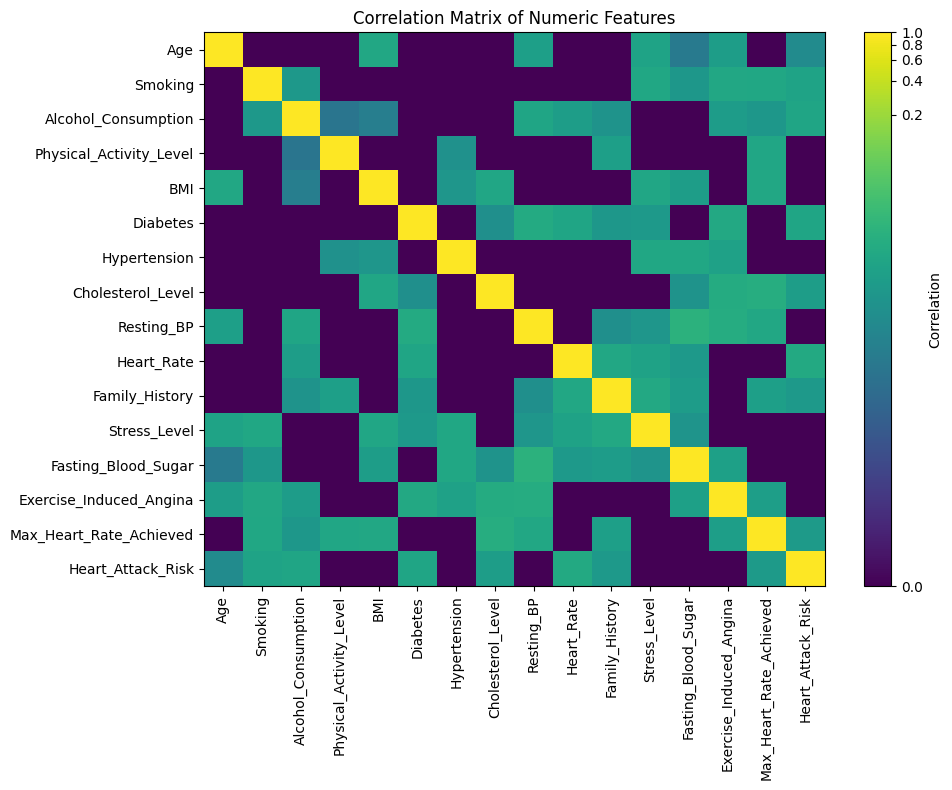

In [14]:
# Correlation Matrix
numeric_df = df.select_dtypes(include=["int64", "float64"])
correlations = numeric_df.corr()

# Set min and max values for color scaling
vmin = 0.0
vmax = 1.0

# Create a custom normalization function to emphasize 0.01–0.3 range
# You can tune gamma to stretch the colors in lower ranges
gamma = 0.1  # Lower gamma => mehr Gewicht auf niedrigen Werten
norm = colors.PowerNorm(gamma=gamma, vmin=vmin, vmax=vmax)

plt.figure(figsize=(10, 8))
im = plt.imshow(correlations, aspect="auto", cmap="viridis", norm=norm)
plt.colorbar(im, label="Correlation")

plt.title("Correlation Matrix of Numeric Features")
plt.xticks(range(len(correlations.columns)), correlations.columns, rotation=90)
plt.yticks(range(len(correlations.columns)), correlations.columns)
plt.tight_layout()
plt.show()

# Training Models with random Forrest

Random Forrest with the non clinical data 

In [12]:
### RF
## N.C.
# training
rf_nc = RandomForestClassifier(n_estimators=100, random_state=42)
rf_nc.fit(x_non_clinical_train, y_non_clinical_train)

# tests
y_pred_nc_rf = rf_nc.predict(x_non_clinical_test)

# f1 stuff
print("Random Forrest Classifier (Non-Clinical) Performance")
print(f"Accuracy: {accuracy_score(y_non_clinical_test, y_pred_nc_rf)}")
print(classification_report(y_non_clinical_test, y_pred_nc_rf))

### RF
## C.
# training
rf_c = RandomForestClassifier(n_estimators=100, random_state=42)
rf_c.fit(x_clinical_train, y_clinical_train)

# tests
y_pred_c_rf = rf_c.predict(x_clinical_test)

# f1 stuff
print("Random Forrest Classifier (Clinical) Performance")
print(f"Accuracy: {accuracy_score(y_clinical_test, y_pred_c_rf)}")
print(classification_report(y_clinical_test, y_pred_c_rf))

### KNN
## N.C.
# training
knn_nc = KNeighborsClassifier(n_neighbors=5)  # You can tune the number of neighbors as needed
knn_nc.fit(x_non_clinical_train, y_non_clinical_train)

# tests
y_pred_nc_knn = knn_nc.predict(x_non_clinical_test)

# f1 stuff
print("K-Nearest Neighbors Classifier (Non-Clinical) Performance")
print(f"Accuracy: {accuracy_score(y_non_clinical_test, y_pred_nc_knn)}")
print(classification_report(y_non_clinical_test, y_pred_nc_knn))

### KNN
## C.
# training
knn_c = KNeighborsClassifier(n_neighbors=5)  # You can tune the number of neighbors as needed
knn_c.fit(x_clinical_train, y_clinical_train)

# tests
y_pred_c_knn = knn_c.predict(x_clinical_test)

# f1 stuff
print("K-Nearest Neighbors Classifier (Clinical) Performance")
print(f"Accuracy: {accuracy_score(y_clinical_test, y_pred_c_knn)}")
print(classification_report(y_clinical_test, y_pred_c_knn))

### Dummy
## N. C.
dummy_nc = DummyClassifier(strategy='most_frequent', random_state=42)

# Train the DummyClassifier on the non-clinical training data
dummy_nc.fit(x_non_clinical_train, y_non_clinical_train)

# Predict on the non-clinical test data
y_pred_dummy_nc = dummy_nc.predict(x_non_clinical_test)

# Evaluate the DummyClassifier
print("Dummy Classifier (Non-Clinical) Performance")
print(f"Accuracy: {accuracy_score(y_non_clinical_test, y_pred_dummy_nc)}")
print(classification_report(y_non_clinical_test, y_pred_dummy_nc))

### Dummy
## C.
dummy_c = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_c.fit(x_clinical_train, y_clinical_train)

# Predict on the clinical test data
y_pred_dummy_c = dummy_c.predict(x_clinical_test)

# Evaluate the DummyClassifier
print("Dummy Classifier (Clinical) Performance")
print(f"Accuracy: {accuracy_score(y_clinical_test, y_pred_dummy_c)}")
print(classification_report(y_clinical_test, y_pred_dummy_c))

Random Forrest Classifier (Non-Clinical) Performance
Accuracy: 0.41386666666666666
              precision    recall  f1-score   support

           1       0.50      0.65      0.56      3747
           2       0.27      0.22      0.24      2185
           3       0.22      0.13      0.16      1568

    accuracy                           0.41      7500
   macro avg       0.33      0.33      0.32      7500
weighted avg       0.38      0.41      0.39      7500

Random Forrest Classifier (Clinical) Performance
Accuracy: 0.4868
              precision    recall  f1-score   support

           1       0.50      0.95      0.65      3747
           2       0.28      0.05      0.08      2185
           3       0.13      0.00      0.01      1568

    accuracy                           0.49      7500
   macro avg       0.30      0.33      0.25      7500
weighted avg       0.36      0.49      0.35      7500

K-Nearest Neighbors Classifier (Non-Clinical) Performance
Accuracy: 0.4382666666666667
  

/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

In [ ]:
# to do 
# normalisieren 
# dann mal auf backpropagraion schauen und so
# und dannach bewerten in wie fern der Datensatz das gut vorhersagen kann weil die Korrelationsmatix arsch aussieht... 

# eventuell ist der output von den nn nicht immer exact 1 2 oder 3 sondern sowas wie 2.8 und so... also anderes encoding yk
# ok bin brain rot what the flip --> Unique predicted classes: [1]

## Neural Network Training Pipeline 

In [ ]:


#-----------------------------------------------------------------
# 2. BUILD A PIPELINE: SCALER + MLP CLASSIFIER
#-----------------------------------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=1))  # We'll tune other params via GridSearch
])

#-----------------------------------------------------------------
# 3. DEFINE A PARAMETER GRID FOR HYPERPARAMETER TUNING
#-----------------------------------------------------------------
param_grid = {
    'mlp__hidden_layer_sizes': [(5, 2), (10, 5), (20, 10), (50, 50)],
    'mlp__alpha': [1e-5, 1e-4, 1e-3],
    # 'mlp__solver': ['adam', 'lbfgs'],  # <--- Remove 'lbfgs'
    'mlp__solver': ['adam', 'sgd'],      # or just ['adam']
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__max_iter': [2000]
}

#-----------------------------------------------------------------
# 4. DEFINE CROSS-VALIDATION STRATEGY
#-----------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# If time-series data, use: cv = TimeSeriesSplit(n_splits=5)


# GRID SEARCH FOR NON-CLINICAL DATA
grid_search_nc = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',  # or 'accuracy', 'roc_auc', etc.
    n_jobs=-1,           
    verbose=1
)

print("Fitting grid search on NON-CLINICAL data...")
grid_search_nc.fit(x_non_clinical_train, y_non_clinical_train)

best_nc_model = grid_search_nc.best_estimator_
print("\nBest params (Non-Clinical):", grid_search_nc.best_params_)
print("Best cross-validation score (Non-Clinical):", grid_search_nc.best_score_)

# Evaluate on test set
y_pred_nc_nn = best_nc_model.predict(x_non_clinical_val)
acc_nc = accuracy_score(y_non_clinical_val, y_pred_nc_nn)
print("\n--- Neural Network Classifier (Non-Clinical) Performance ---")
print(f"Test Accuracy: {acc_nc:.4f}")
print(classification_report(y_non_clinical_val, y_pred_nc_nn))

grid_search_c = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

print("\nFitting grid search on CLINICAL data...")
grid_search_c.fit(x_clinical_train, y_clinical_train)

best_c_model = grid_search_c.best_estimator_
print("\nBest params (Clinical):", grid_search_c.best_params_)
print("Best cross-validation score (Clinical):", grid_search_c.best_score_)

# Evaluate on test set
y_pred_c_nn = best_c_model.predict(x_clinical_val)
acc_c = accuracy_score(y_clinical_val, y_pred_c_nn)
print("\n--- Neural Network Classifier (Clinical) Performance ---")
print(f"Test Accuracy: {acc_c:.4f}")
print(classification_report(y_clinical_val, y_pred_c_nn))


In [ ]:
#-----------------------------------------------------------------
# 2. BUILD A PIPELINE: SCALER + MLP CLASSIFIER
#-----------------------------------------------------------------
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(random_state=1))  # We'll tune other params via GridSearch
])

#-----------------------------------------------------------------
# 3. DEFINE A PARAMETER GRID FOR HYPERPARAMETER TUNING
#-----------------------------------------------------------------
param_grid = {
    'mlp__hidden_layer_sizes': [(5, 2), (10, 5), (20, 10), (50, 50)],
    'mlp__alpha': [1e-5, 1e-4, 1e-3],
    # 'mlp__solver': ['adam', 'lbfgs'],  # <--- Remove 'lbfgs'
    'mlp__solver': ['adam', 'sgd'],      # or just ['adam']
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__max_iter': [2000]
}

#-----------------------------------------------------------------
# 4. DEFINE CROSS-VALIDATION STRATEGY
#-----------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# If time-series data, use: cv = TimeSeriesSplit(n_splits=5)


# GRID SEARCH FOR NON-CLINICAL DATA
grid_search_nc = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy', 
    n_jobs=-1,           
    verbose=1
)

print("Fitting grid search on NON-CLINICAL data...")
grid_search_nc.fit(x_non_clinical_train, y_non_clinical_train)

best_nc_model = grid_search_nc.best_estimator_
print("\nBest params (Non-Clinical):", grid_search_nc.best_params_)
print("Best cross-validation score (Non-Clinical):", grid_search_nc.best_score_)

# Evaluate on test set
y_pred_nc_nn = best_nc_model.predict(x_non_clinical_val)
acc_nc = accuracy_score(y_non_clinical_val, y_pred_nc_nn)
print("\n--- Neural Network Classifier (Non-Clinical) Performance ---")
print(f"Test Accuracy: {acc_nc:.4f}")
print(classification_report(y_non_clinical_val, y_pred_nc_nn))

grid_search_c = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nFitting grid search on CLINICAL data...")
grid_search_c.fit(x_clinical_train, y_clinical_train)

best_c_model = grid_search_c.best_estimator_
print("\nBest params (Clinical):", grid_search_c.best_params_)
print("Best cross-validation score (Clinical):", grid_search_c.best_score_)

# Evaluate on test set
y_pred_c_nn = best_c_model.predict(x_clinical_val)
acc_c = accuracy_score(y_clinical_val, y_pred_c_nn)
print("\n--- Neural Network Classifier (Clinical) Performance ---")
print(f"Test Accuracy: {acc_c:.4f}")
print(classification_report(y_clinical_val, y_pred_c_nn))

Fitting grid search on NON-CLINICAL data...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params (Non-Clinical): {'mlp__alpha': 1e-05, 'mlp__hidden_layer_sizes': (5, 2), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 2000, 'mlp__solver': 'adam'}
Best cross-validation score (Non-Clinical): 0.5018857142857143

--- Neural Network Classifier (Non-Clinical) Performance ---
Test Accuracy: 0.4948
              precision    recall  f1-score   support

           1       0.49      1.00      0.66      3711
           2       0.00      0.00      0.00      2296
           3       0.00      0.00      0.00      1493

    accuracy                           0.49      7500
   macro avg       0.16      0.33      0.22      7500
weighted avg       0.24      0.49      0.33      7500


Fitting grid search on CLINICAL data...
Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi


Best params (Clinical): {'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (5, 2), 'mlp__learning_rate_init': 0.001, 'mlp__max_iter': 2000, 'mlp__solver': 'adam'}
Best cross-validation score (Clinical): 0.502

--- Neural Network Classifier (Clinical) Performance ---
Test Accuracy: 0.4948
              precision    recall  f1-score   support

           1       0.49      1.00      0.66      3711
           2       0.00      0.00      0.00      2296
           3       0.00      0.00      0.00      1493

    accuracy                           0.49      7500
   macro avg       0.16      0.33      0.22      7500
weighted avg       0.24      0.49      0.33      7500



/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/bastianlipka/Desktop/UNI/Semester 4/Exploration Project/Abgabe/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi